In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from highlight_text import ax_text, fig_text
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
data = pd.read_csv('Rat_Sightings.csv')

In [3]:
data.head(2)

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Latitude,Longitude,Location
0,46227627,05/17/2020 03:59:40 PM,NaN,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,3+ Family Apt. Building,11218.0,39 TURNER PLACE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.645350,-73.970318,"(40.64534954262103, -73.97031798578249)"
1,46224835,05/18/2020 12:16:40 AM,05/18/2020 12:16:40 AM,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,3+ Family Apt. Building,11237.0,197 STOCKHOLM STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.700173,-73.922140,"(40.7001731422613, -73.92214009506347)"


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234999 entries, 0 to 234998
Data columns (total 38 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Unique Key                      234999 non-null  int64  
 1   Created Date                    234999 non-null  object 
 2   Closed Date                     217947 non-null  object 
 3   Agency                          234999 non-null  object 
 4   Agency Name                     234999 non-null  object 
 5   Complaint Type                  234999 non-null  object 
 6   Descriptor                      234999 non-null  object 
 7   Location Type                   234987 non-null  object 
 8   Incident Zip                    234568 non-null  float64
 9   Incident Address                224063 non-null  object 
 10  Street Name                     224062 non-null  object 
 11  Cross Street 1                  208620 non-null  object 
 12  Cross Street 2  

In [5]:
# Create a GeoDataFrame
geometry = [Point(xy) for xy in zip(data['Longitude'], data['Latitude'])]
gdf = gpd.GeoDataFrame(data, geometry=geometry, crs="EPSG:4326")

In [6]:
# Convert to Web Mercator projection 
gdf = gdf.to_crs(epsg=3857)

In [7]:
gdf.head(2)

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Latitude,Longitude,Location,geometry
0,46227627,05/17/2020 03:59:40 PM,NaN,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,3+ Family Apt. Building,11218.0,39 TURNER PLACE,...,NaN,NaN,NaN,NaN,NaN,NaN,40.645350,-73.970318,"(40.64534954262103, -73.97031798578249)",POINT (-8234338.132 4960170.703)
1,46224835,05/18/2020 12:16:40 AM,05/18/2020 12:16:40 AM,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,3+ Family Apt. Building,11237.0,197 STOCKHOLM STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,40.700173,-73.922140,"(40.7001731422613, -73.92214009506347)",POINT (-8228974.994 4968217.353)


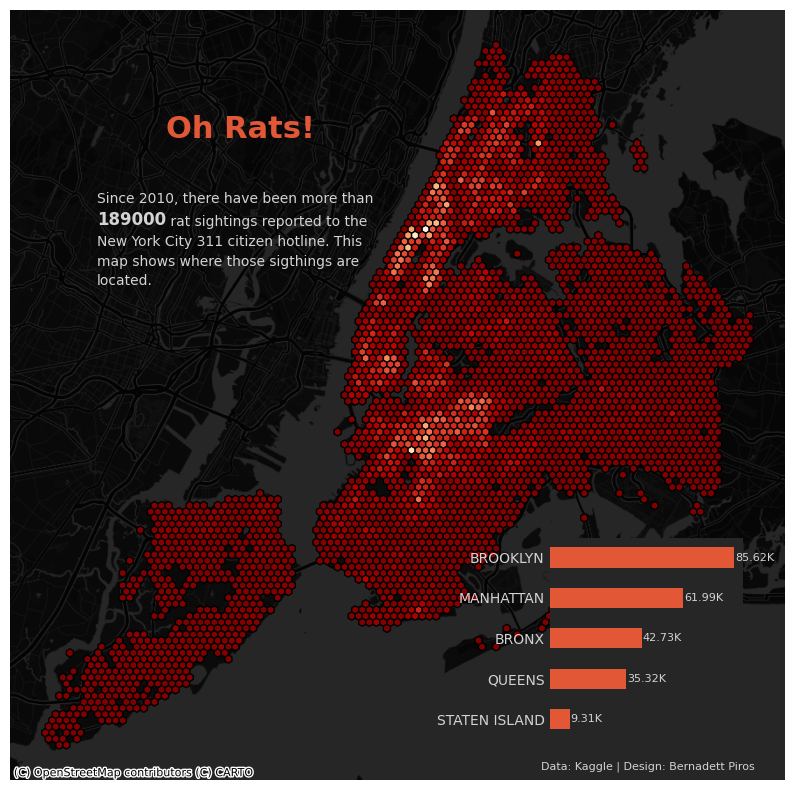

In [8]:
# Create hexbin plot
fig, ax = plt.subplots(figsize=(10, 10))
ax.axis('off')

# Create the hexbin
hb = ax.hexbin(gdf.geometry.x, gdf.geometry.y, 
               gridsize=100, cmap='OrRd_r', mincnt=1, reduce_C_function=np.sum, edgecolors='black')

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.DarkMatterNoLabels)

# Add texts

text_title = f"""
<Oh Rats!>
"""
fig_text(
   0.355, 0.76,
   text_title,
   fontsize=8,
   ha='center', va='center',
   color='lightgrey', 
   highlight_textprops=[
      {'fontweight': 'bold', 'color':'#e25836', 'fontsize': 22}
      ],
   fig=fig
)

text = f"""
Since 2010, there have been more than
<189000> rat sightings reported to the
New York City 311 citizen hotline. This
map shows where those sigthings are
located.
"""
fig_text(
   0.35, 0.65,
   text,
   fontsize=10,
   ha='center', va='center',
   color='lightgrey', 
   highlight_textprops=[
      {'fontweight': 'bold', 'fontsize': 12}
   ],
   fig=fig
)

# Create inset axes
inset_ax = inset_axes(ax, width="25%", height=2, loc="lower right", borderpad=3)
inset_ax.set_facecolor('#262626')  
inset_ax.tick_params(labelcolor='lightgrey', length=0)
inset_ax.spines['bottom'].set_color('none')
inset_ax.spines['top'].set_color('none')
inset_ax.spines['right'].set_color('none')
inset_ax.spines['left'].set_color('none')

# Filter out 'Unspecified' 
fd = data[data['Borough'] != 'Unspecified']

# Group by 'borough' and count the number of rows
bcounts = fd['Borough'].value_counts()

# Reverse the order of bars
bcounts = bcounts.iloc[::-1]

# Create bar plot
bars = inset_ax.barh(y=bcounts.index, width=bcounts.values, height=0.5, color='#e25836', zorder=2)
for bar, count in zip(bars, bcounts.values):
    inset_ax.text(bar.get_width() + 500, bar.get_y() + bar.get_height() / 2,
                  '{:.2f}K'.format(count / 1000),
                  ha='left', va='center', fontsize=8, color='lightgrey')

inset_ax.xaxis.set_visible(False)
plt.grid(axis='x', zorder=1, color='grey')

fig.text(0.87, 0.12, "Data: Kaggle | Design: Bernadett Piros", color='lightgrey', fontsize=8, ha="right")

# Show plot
plt.show()

#plt.savefig("oh_rats", bbox_inches='tight', pad_inches=0.2)